In [ ]:
!pip install lexicalrichness
!pip install textstat
!pip install plotly==4.11.0
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tag import pos_tag
from nltk import word_tokenize
from collections import Counter

import textstat
from lexicalrichness import LexicalRichness

import plotly.express as px
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.graph_objects as go
# pyo.init_notebook_mode()
# from plotly.offline import iplot as pyo


from collections import Counter
import pickle
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import re
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
from google.colab import files
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '1JrrEB2diNCx92tD8COV466dc3Qb2MM7g'})
download.GetContentFile('final_merge_cov.csv')

In [ ]:
pd.set_option('display.max_columns', 500)
df = pd.read_csv('final_merge_cov.csv')
df.head()

title text source        label
0   Doctors perfoms a c-section in COVID-19 pacie...  NaN    NaN   MISLEADING
1   Sweden has a lower COVID-19 death rate than S...  NaN    NaN   MISLEADING
2   Homemade masks prevent the spread of coronavi...  NaN    NaN  Explanatory
3   An image has been shared repeatedly on Facebo...  NaN    NaN   MISLEADING
4   Data show the pandemic is losing its strength...  NaN    NaN   MISLEADING

In [ ]:
# df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
# df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
# df.loc[df['label'] == 'true', ['label']] = 'TRUE'
# df.loc[df['label'] == 'Misleading', ['label']] = 'MISLEADING'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)
Counter(df['label'])

Counter({'Explanatory': 59, 'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

In [ ]:
# Checking if there is any NaN values and their indexes
df['label'].isnull().sum()
df[df['label'].isnull()].index.tolist()

[]

Text(0.5, 1.0, 'Data distribution of fake, true, misleading and explanatory data')

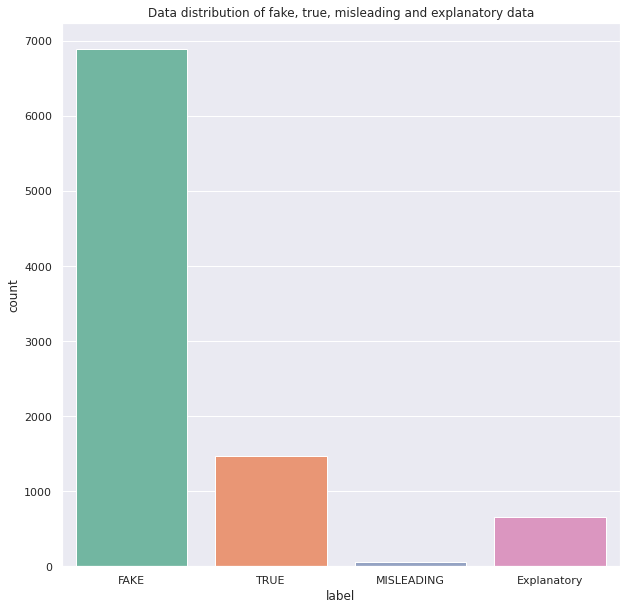

In [ ]:
plt.figure(figsize=(10, 10))
sns.set(style="darkgrid")

color = sns.color_palette("Set2")
ax = sns.countplot(x="label", data=df, palette=color)

ax.set(xticklabels=['FAKE', 'TRUE', 'MISLEADING', 'Explanatory'])

plt.title("Data distribution of fake, true, misleading and explanatory data")

In [ ]:
df1 = df
df1.head()

title  \
0   President of Italy crying because of the coro...   
1   People with type A blood are more prone to ge...   
2   Staff of Gold Coast Hospital in Australia has...   
3   Ibuprofen aggravates patients with the new co...   
4  Great prevention advice , please share with al...   

                                                text    source label  
0   President of Italy crying because of the coro...   missing  FAKE  
1   People with type A blood are more prone to ge...   missing  FAKE  
2   Staff of Gold Coast Hospital in Australia has...   missing  FAKE  
3   Ibuprofen aggravates patients with the new co...   missing  FAKE  
4  Be understing, a Japanese doctor offers excell...  Facebook  FAKE

### Data Cleaning

In [ ]:
def clean_train_data(x):
    text = x
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\n', '', text)
    return text

In [ ]:
clean_combine_data = df1.copy()
clean_combine_data['title'] = df1.title.apply(lambda x : clean_train_data(x))
clean_combine_data.head()

title  \
0   president of italy crying because of the coro...   
1   people with type a blood are more prone to ge...   
2   staff of gold coast hospital in australia has...   
3   ibuprofen aggravates patients with the new co...   
4  great prevention advice  please share with all...   

                                                text    source label  
0   President of Italy crying because of the coro...   missing  FAKE  
1   People with type A blood are more prone to ge...   missing  FAKE  
2   Staff of Gold Coast Hospital in Australia has...   missing  FAKE  
3   Ibuprofen aggravates patients with the new co...   missing  FAKE  
4  Be understing, a Japanese doctor offers excell...  Facebook  FAKE

In [ ]:
clean_combine_data.tail()

title  \
9072   pakistans dr usama riaz who contracted corona...   
9073   people sneezing purposefully to spread corona...   
9074   images of a bruised youth claimed to be marks...   
9075  coronavirus symptoms what are they and how do ...   
9076  coronavirus panic what the media is not tellin...   

                                                   text  \
9072   Pakistan’s Dr. Usama Riaz, who contracted cor...   
9073   People sneezing purposefully to spread corona...   
9074   Images of a bruised youth claimed to be marks...   
9075  Loss of smell or taste have been added to the ...   
9076  As of March 3, the coronavirus mortality rate ...   

                         source       label  
9072                    missing        FAKE  
9073                    missing  MISLEADING  
9074                    missing        FAKE  
9075       https://www.bbc.com/        TRUE  
9076  https://techstartups.com/        FAKE

### Stopword Removal


In [ ]:
eng_stopwords = stop_words

In [ ]:
def remove_eng_stopwords(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [word for word in token_text if word not in eng_stopwords]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
nltk.download('punkt')
stopword_combine_data = clean_combine_data.copy()
stopword_combine_data['title'] = clean_combine_data.title.apply(lambda x : remove_eng_stopwords(x))
stopword_combine_data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


title  \
0        president italy crying coronavirus pandemic   
1        people type blood prone get new coronavirus   
2  staff gold coast hospital australia gifted vol...   
3      ibuprofen aggravates patients new coronavirus   
4    great prevention advice please share loved ones   

                                                text    source label  
0   President of Italy crying because of the coro...   missing  FAKE  
1   People with type A blood are more prone to ge...   missing  FAKE  
2   Staff of Gold Coast Hospital in Australia has...   missing  FAKE  
3   Ibuprofen aggravates patients with the new co...   missing  FAKE  
4  Be understing, a Japanese doctor offers excell...  Facebook  FAKE

### Find out common words

In [ ]:
from itertools import chain
from collections import Counter

In [ ]:
list_words = stopword_combine_data['title'].str.split()
list_words_merge = list(chain(*list_words))

d = Counter(list_words_merge)
df2 = pd.DataFrame(data=d, index=['count'])
top_common_words = df2.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
top_common_words.head()

index  count
0  coronavirus   3576
1       people    840
2        video    833
3        shows    616
4          new    523

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text major ticklabel objects>)

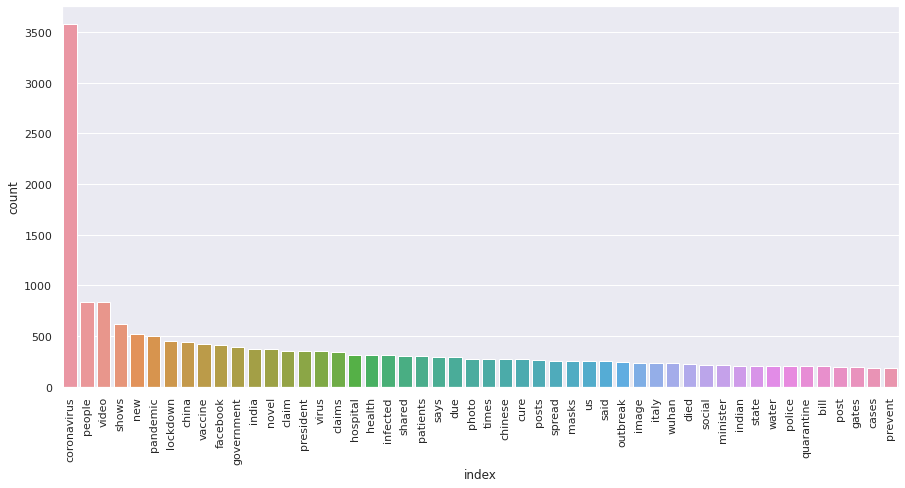

In [ ]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.barplot(x="index", y='count', data=top_common_words)
plt.xticks(rotation=90)

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
lemm = WordNetLemmatizer()

In [ ]:
def word_lemmatizer(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [lemm.lemmatize(w) for w in token_text]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
nltk.download('wordnet')
lemmatize_data = stopword_combine_data.copy()
lemmatize_data['title'] = stopword_combine_data.title.apply(lambda x : word_lemmatizer(x))
lemmatize_data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


title  \
0           president italy cry coronavirus pandemic   
1        people type blood prone get new coronavirus   
2  staff gold coast hospital australia gifted vol...   
3       ibuprofen aggravates patient new coronavirus   
4     great prevention advice please share loved one   

                                                text    source label  
0   President of Italy crying because of the coro...   missing  FAKE  
1   People with type A blood are more prone to ge...   missing  FAKE  
2   Staff of Gold Coast Hospital in Australia has...   missing  FAKE  
3   Ibuprofen aggravates patients with the new co...   missing  FAKE  
4  Be understing, a Japanese doctor offers excell...  Facebook  FAKE

### N-Gram Analysis

In [ ]:
string = ' '.join(lemmatize_data['title'])

In [ ]:
str_val = string.split(" ")

### Unigram Analysis

In [ ]:
data_unigram=(pd.Series(nltk.ngrams(str_val, 1)).value_counts())[:30]

In [ ]:
data_unigram_df = pd.DataFrame(data_unigram)
data_unigram_df = data_unigram_df.reset_index()
data_unigram_df = data_unigram_df.rename(columns={"index": "key", 0: "value"})
data_unigram_df.head()

key  value
0  (coronavirus,)   3576
1        (video,)    862
2       (people,)    861
3         (show,)    763
4        (claim,)    701

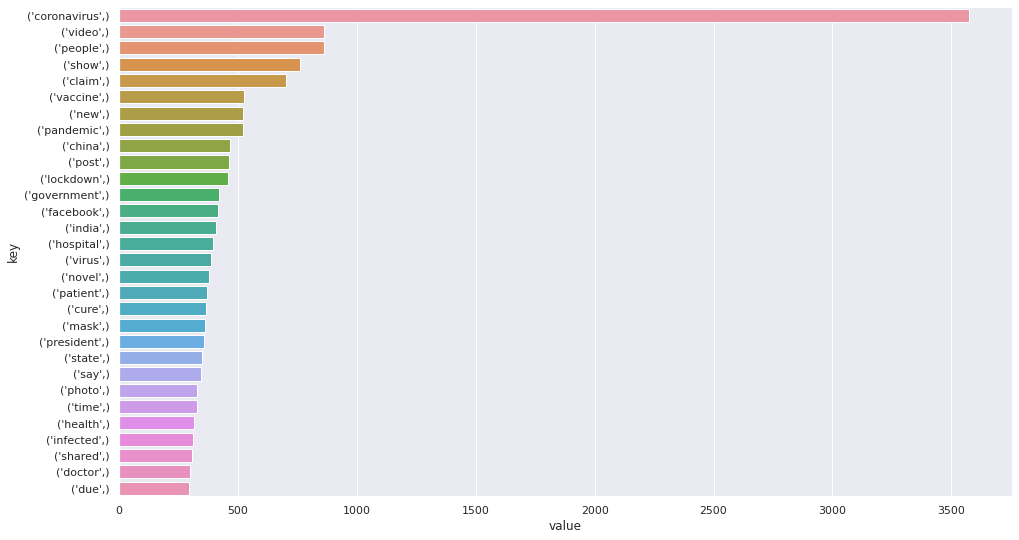

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_unigram_df)

### Bigram Analysis

In [ ]:
data_bigram = (pd.Series(nltk.ngrams(str_val, 2)).value_counts())[:30]

In [ ]:
data_bigram_df = pd.DataFrame(data_bigram)
data_bigram_df = data_bigram_df.reset_index()
data_bigram_df = data_bigram_df.rename(columns={"index": "key", 0: "value"})
data_bigram_df.head()

key  value
0     (novel, coronavirus)    371
1       (new, coronavirus)    305
2            (video, show)    244
3  (coronavirus, pandemic)    172
4         (thousand, time)    162

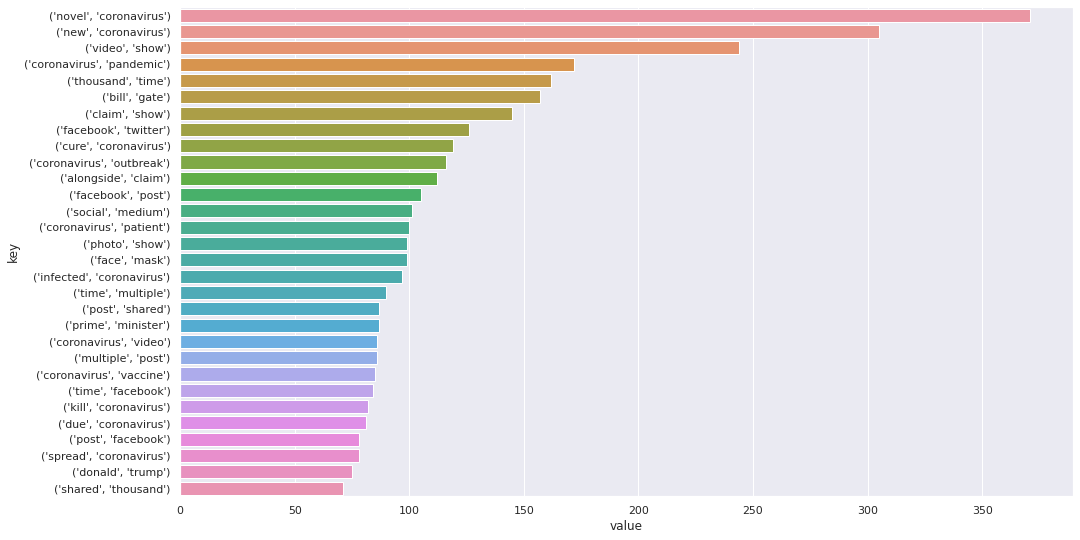

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_bigram_df)

### Trigram Analysis

In [ ]:
data_trigram = (pd.Series(nltk.ngrams(str_val, 3)).value_counts())[:30]

In [ ]:
data_trigram_df = pd.DataFrame(data_trigram)
data_trigram_df = data_trigram_df.reset_index()
data_trigram_df = data_trigram_df.rename(columns={"index": "key", 0: "value"})
data_trigram_df.head()

key  value
0    (alongside, claim, show)     83
1    (shared, thousand, time)     71
2  (multiple, post, facebook)     68
3  (thousand, time, multiple)     67
4      (time, multiple, post)     59

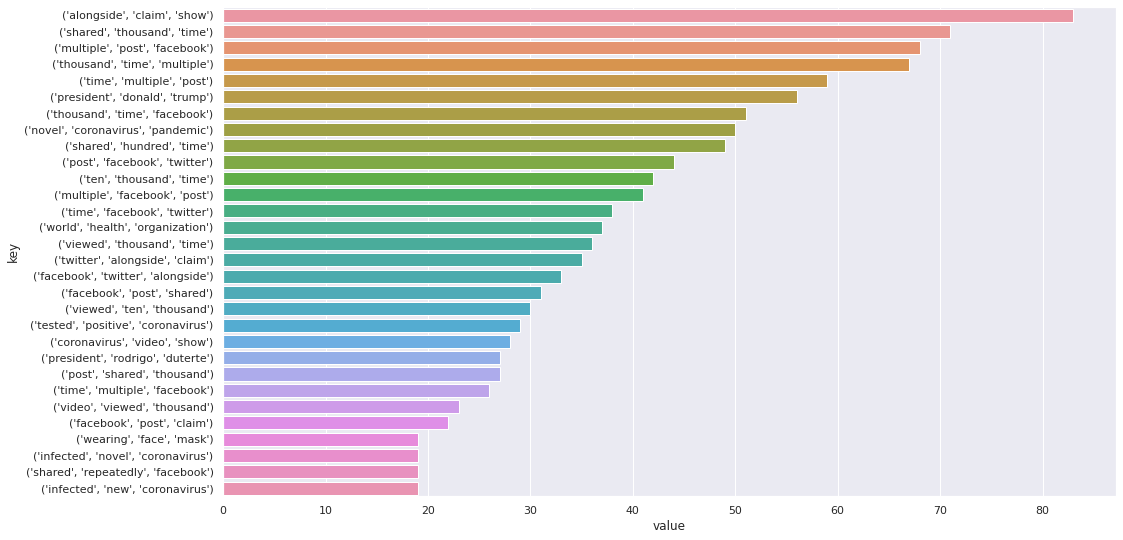

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x='value',y='key', data=data_trigram_df)

### Modeling

In [ ]:
model_data = lemmatize_data.copy()
model_data['combine_title'] = model_data['title']
model_data = model_data[['label', 'combine_title']]

model_data.head()

label                                      combine_title
0  FAKE           president italy cry coronavirus pandemic
1  FAKE        people type blood prone get new coronavirus
2  FAKE  staff gold coast hospital australia gifted vol...
3  FAKE       ibuprofen aggravates patient new coronavirus
4  FAKE     great prevention advice please share loved one

In [ ]:
# %matplotlib inline
from wordcloud import WordCloud
all_words = ' '.join([text for text in model_data.combine_title])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

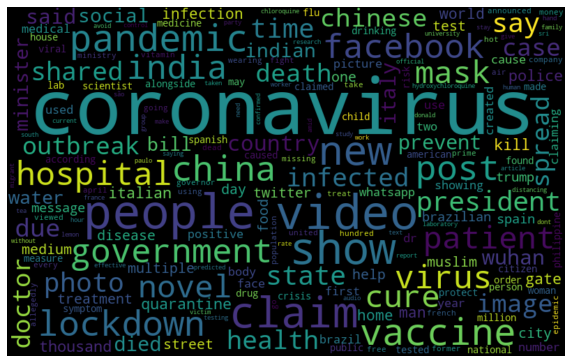

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We will divide the data in to fake, true and misleading catagories

In [ ]:
def wordcloud_true(text, column_title):
    true_text = text.query("label == 'TRUE'")
    all_words = ' '.join([text for text in true_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def wordcloud_fake(text, column_title):
    fake_text = text.query("label == 'FAKE'")
    all_words = ' '.join([text for text in fake_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def wordcloud_misleading(text, column_title):
    misleading_text = text.query("label == 'MISLEADING'")
    all_words = ' '.join([text for text in misleading_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def wordcloud_explanatory(text, column_title):
    explanatory_text = text.query("label == 'Explanatory'")
    all_words = ' '.join([text for text in explanatory_text[column_title]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Wordcloud of the true news. 

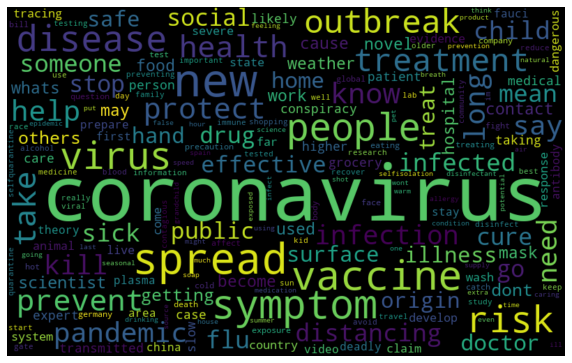

In [ ]:
wordcloud_true(model_data, "combine_title")

### Wordcloud of the fake news.

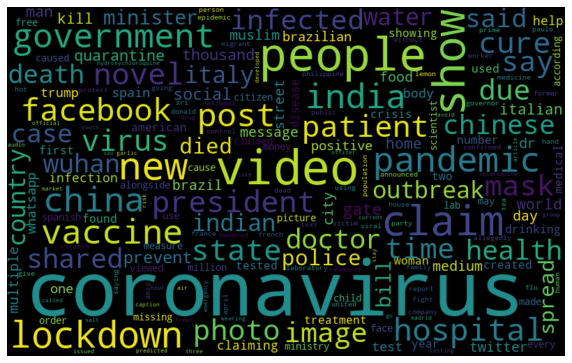

In [ ]:
wordcloud_fake(model_data, "combine_title")

### Wordcloud of the misleading news.


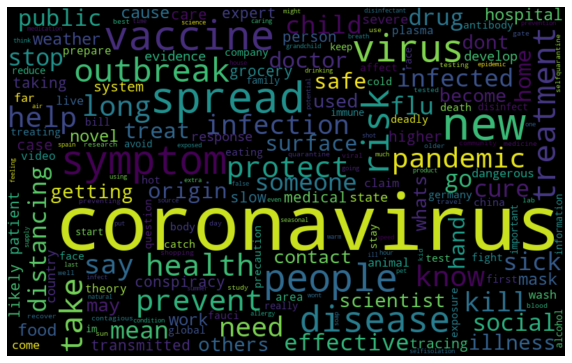

In [ ]:
wordcloud_true(model_data, "combine_title")

### Wordcloud of the explanatory news.


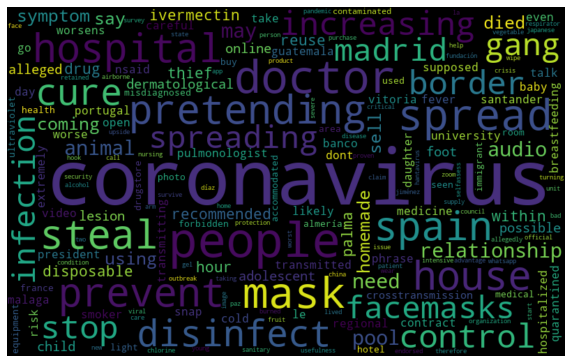

In [ ]:
wordcloud_explanatory(model_data, "combine_title")

**Frequencies of Words**

Now we will plot the pareto chart to better visualize the frequencies of the words.

In [ ]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()

In [ ]:
def pareto(text, column_title, quantity):
    all_words = ' '.join([text for text in text[column_title]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.show()

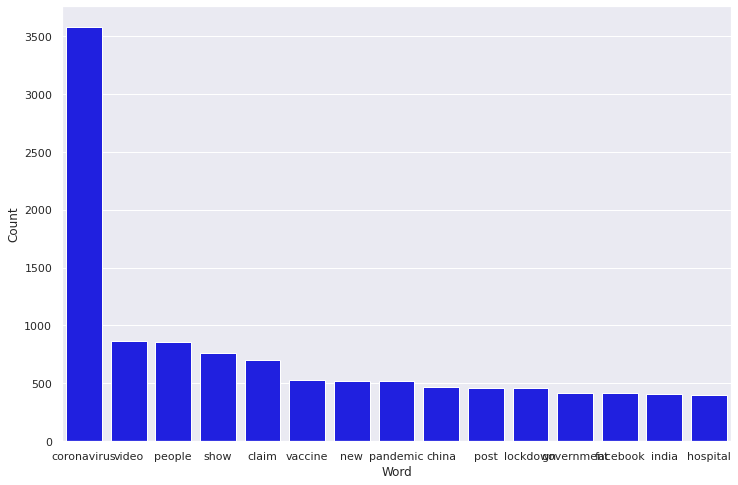

In [ ]:
pareto(model_data, "combine_title", 15)

In [ ]:
model_data[model_data['label']=='MISLEADING']

label                                      combine_title
5     MISLEADING  governor mexico omar fayad said twitter vitami...
27    MISLEADING  japanese prime minister shinzo abe announced c...
41    MISLEADING                    fragment found nonpotable water
46    MISLEADING  message linking scientist bing lius death sign...
49    MISLEADING  take clothes shoe outside wash disinfectant vi...
...          ...                                                ...
9061  MISLEADING  germany cancel strict quarantine open shop mus...
9062  MISLEADING  multiple online article social medium post pub...
9065  MISLEADING  viral video claim show visuals china police pe...
9070  MISLEADING                  viral video claim mass graf italy
9073  MISLEADING  people sneezing purposefully spread coronaviru...

[1464 rows x 2 columns]

In [ ]:
model_data[model_data['label']=='Explanatory']

label                                      combine_title
10    Explanatory  increasing border control stop coronavirus spr...
34    Explanatory            facemasks prevent coronavirus infection
74    Explanatory   gang madrid pretending doctor steal people house
724   Explanatory           homemade mask prevent spread coronavirus
853   Explanatory  thief palma spain pretending doctor steal peop...
918   Explanatory  using drug ivermectin cure coronavirus within ...
1038  Explanatory  increasing border control stop coronavirus spr...
1225  Explanatory                  usefulness homemade chlorine wipe
1251  Explanatory        recommended disinfect disposable mask reuse
1672  Explanatory  sanitary protection supply retained la paz hos...
1766  Explanatory  dermatological lesion foot child adolescent po...
1787  Explanatory                 coronavirus spread fruit vegetable
1823  Explanatory       online survey selfassess coronavirus symptom
2097  Explanatory  audio alleged pulmonologist regional universit...
2267  Explanatory          smoker le likely hospitalized coronavirus
2279  Explanatory           homemade mask prevent spread coronavirus
2458  Explanatory      new outbreak pandemic hantavirus coming china
2613  Explanatory  gang vitoria pretending doctor steal people house
2687  Explanatory   gang madrid pretending doctor steal people house
2740  Explanatory   pool open guatemala coronavirus transmitted pool
2924  Explanatory  audio alleged pulmonologist regional universit...
3014  Explanatory            facemasks prevent coronavirus infection
3108  Explanatory        recommended disinfect disposable mask reuse
3139  Explanatory            facemasks prevent coronavirus infection
3276  Explanatory           dont take nsaid medicine worsens symptom
3431  Explanatory  relationship breastfeeding risk transmitting c...
3602  Explanatory          smoker le likely hospitalized coronavirus
3969  Explanatory   audio state worst coronavirus crisis spain start
4172  Explanatory  gang vitoria pretending doctor steal people house
4361  Explanatory  supposed phrase daughter president banco santa...
4412  Explanatory  relationship breastfeeding risk transmitting c...
4479  Explanatory   people died coronavirus spain lived nursing home
4686  Explanatory                   coronavirus spread people animal
4855  Explanatory  viral audio whatsapp doctor hospital fundación...
4945  Explanatory  increasing border control stop coronavirus spr...
5282  Explanatory                 security issue zoom video call app
5298  Explanatory  extremely careful coming cold snap get fever n...
5319  Explanatory           drugstore france forbidden buy sell mask
5554  Explanatory                          coronavirus spread animal
5792  Explanatory           drugstore france forbidden buy sell mask
5830  Explanatory  purchase health product health council taking ...
6036  Explanatory  photo room hotel almería spain immigrant accom...
6093  Explanatory  increasing border control stop coronavirus spr...
6130  Explanatory                          coronavirus spread animal
6135  Explanatory  image arm burned allegedly using gel alcohol d...
6268  Explanatory                   coronavirus spread people animal
6367  Explanatory  ultraviolet light used disinfect area contamin...
6394  Explanatory  photo room hotel almería spain immigrant accom...
6465  Explanatory   pool open guatemala coronavirus transmitted pool
6590  Explanatory  ultraviolet light used disinfect area contamin...
6614  Explanatory  dermatological lesion foot child adolescent po...
6783  Explanatory  video say japanese doctor proven coronavirus a...
7123  Explanatory  using drug ivermectin cure coronavirus within ...
7443  Explanatory  supposed phrase daughter president banco santa...
7509  Explanatory  thief palma spain pretending doctor steal peop...
7567  Explanatory  turning severe person coronavirus upside help ...
8189  Explanatory           dont take nsaid medicine worsens symptom
8300  Expl

In [ ]:
model_data = model_data.sample(frac=1).reset_index(drop=True)
model_data

label                                      combine_title
0           TRUE                            risk getting exercising
1           FAKE  special report mike adam join alex jones revea...
2           FAKE  video show lockdown social distancing violatio...
3     MISLEADING              new coronavirus survives shoe surface
4           FAKE                   possible origin coronavirus part
...          ...                                                ...
9072        FAKE  news outlet misusing boy image report child di...
9073        FAKE  amid lockdown food distributed indian state ta...
9074        FAKE  photo prime minister italy cry expressing help...
9075        FAKE     inhaling mixture peppermint oil clove oil cure
9076        FAKE  elisa granato first volunteer first europe hum...

[9077 rows x 2 columns]

In [ ]:
model_data = model_data[model_data.label != 'Explanatory']
Counter(model_data['label'])

Counter({'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

In [ ]:
model_data['combine_title']

0                                 risk getting exercising
1       special report mike adam join alex jones revea...
2       video show lockdown social distancing violatio...
3                   new coronavirus survives shoe surface
4                        possible origin coronavirus part
                              ...                        
9072    news outlet misusing boy image report child di...
9073    amid lockdown food distributed indian state ta...
9074    photo prime minister italy cry expressing help...
9075       inhaling mixture peppermint oil clove oil cure
9076    elisa granato first volunteer first europe hum...
Name: combine_title, Length: 9018, dtype: object

###**Logistic Regression**

In [ ]:
def preprocessor(text):
    
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()

    return text

In [ ]:
model_data['combine_title'] = model_data['combine_title'].apply(preprocessor)

In [ ]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [ ]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
X_1 = tfidf.fit_transform(model_data['combine_title'])
y_1 = model_data.label.values

### Split Data & Modelling (Logistic Regression)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, random_state=0, test_size=0.5, shuffle=False)

In [ ]:
clf2 = LogisticRegressionCV(cv=5, scoring='accuracy', random_state=0, n_jobs=-1, verbose=3, max_iter=300).fit(X_train1, y_train1)

fake_news_model = open('fake_news_model.sav', 'wb')
pickle.dump(clf2, fake_news_model)
fake_news_model.close()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.1s finished


In [ ]:
filename = 'fake_news_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

saved_clf.score(X_test1, y_test1)

0.7817697937458417

In [ ]:
y_pred1 = clf2.predict(X_test1)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test1, y_pred1)))
print(classification_report(y_test1, y_pred1))

---Test Set Results---
Accuracy with logreg: 0.7817697937458417
              precision    recall  f1-score   support

        FAKE       0.80      0.97      0.88      3463
  MISLEADING       0.43      0.13      0.20       711
        TRUE       0.76      0.25      0.38       335

    accuracy                           0.78      4509
   macro avg       0.66      0.45      0.49      4509
weighted avg       0.74      0.78      0.73      4509



###**Naive Bayes**

In [ ]:
length_doc_text = model_data['combine_title']
length_lebel = model_data['label']
split_point_1 = int(0.80*len(length_doc_text))
trainDoc_1 = length_doc_text[:split_point_1]
trainClass_1 = length_lebel[:split_point_1]
testDoc_1 = length_doc_text[split_point_1:]
testClass_1 = length_lebel[split_point_1:]

In [ ]:
testData = model_data.sample(frac=1).reset_index(drop=True)
testData

label                                      combine_title
0           FAKE  andalusia proposes student must repeat class m...
1           FAKE  illuminati controlled u government coronavirus...
2           TRUE   made qa know video people fainting middle street
3           FAKE  president donald trump referred coronavirus ho...
4           FAKE               holding breath let check coronavirus
...          ...                                                ...
9013  MISLEADING  official news naples people used tocilizumab d...
9014        FAKE                                            missing
9015        FAKE  meme show florida surgeon general saying every...
9016        FAKE  coronavirus fear wifi network could acting acc...
9017        TRUE             could contact tracing help slow spread

[9018 rows x 2 columns]

In [ ]:
from collections import Counter
testClassList = testClass_1.tolist()
Counter(testClassList)

Counter({'FAKE': 1423, 'MISLEADING': 255, 'TRUE': 126})

In [ ]:
# a dummy function that just returns its input
def identity(x):
    return x

In [ ]:
def Multinomial_Naive_Bayes(trainDoc, trainClass, testDoc, testClass, tfIdf):

    # we use a dummy function as tokenizer and preprocessor,
    # since the texts are already preprocessed and tokenized.
    if tfIdf:
        vec = TfidfVectorizer(preprocessor = identity,
                              tokenizer = identity)
   

    # Pipeline combines the vectorizers with a Naive Bayes classifier
    classifier = Pipeline( [('vec', vec),
                            ('cls', MultinomialNB(alpha=.01))] )


    # Train the classifier and build a model using the training documents
    classifier.fit(trainDoc, trainClass)
    
    #saving the model
    from sklearn.externals import joblib
    joblib.dump(classifier, 'NB_model.pkl')
    
    # Outputs Predicted class for the test set
    testGuess = classifier.predict(testDoc)
    
#     try:
#         #inputfile = open("input_nb.txt","r", encoding='utf-8')
#         valDOC, valLBL = read_corpus('input_nb.txt', use_sentiment=False)
#         predz = classifier.predict(valDOC)
#         i=0
#         for line in valDOC:
#             print(line, predz[i])
#             i+=1
#         #inputfile.close()
#     except:
#         pass

    prec, rec, f1, tureSum= precision_recall_fscore_support(testClass, testGuess)
    #classguess = classifier.predict(predict)
    #print("predicted class:", classguess)

    # Simply calculates the accuracy score using the Gold Labels and Predicted Labels
    print("Naive Bayes with TF-idf:")
    accuracy = accuracy_score(testClass, testGuess)
    print("Accuracy = "+str(accuracy))
    print("\n")
    # Showing the Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(testClass, testGuess, labels=classifier.classes_)
    prec, rec, f1, tureSum= precision_recall_fscore_support(testClass, testGuess)
    print(classifier.classes_)
    print(cm)
    print('\n\n...........Classification Report...........')
    print(classification_report(testClass, testGuess))


In [ ]:
Multinomial_Naive_Bayes(trainDoc_1, trainClass_1, testDoc_1, testClass_1, tfIdf=True)

Naive Bayes with TF-idf:
Accuracy = 0.7888026607538803



Confusion Matrix:
['FAKE' 'MISLEADING' 'TRUE']
[[1423    0    0]
 [ 255    0    0]
 [ 126    0    0]]


...........Classification Report...........
              precision    recall  f1-score   support

        FAKE       0.79      1.00      0.88      1423
  MISLEADING       0.00      0.00      0.00       255
        TRUE       0.00      0.00      0.00       126

    accuracy                           0.79      1804
   macro avg       0.26      0.33      0.29      1804
weighted avg       0.62      0.79      0.70      1804



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
df['title_num_uppercase'] = df['title'].str.count(r'[A-Z]')
df['title_len'] = df['title'].str.len()

df['text_num_uppercase'] = df['text'].str.count(r'[A-Z]')
df['text_len'] = df['text'].str.len()

df['title_pct_uppercase'] = df.title_num_uppercase.div(df.title_len)
df['text_pct_uppercase'] = df.text_num_uppercase.div(df.text_len)
df

title  \
0      President of Italy crying because of the coro...   
1      People with type A blood are more prone to ge...   
2      Staff of Gold Coast Hospital in Australia has...   
3      Ibuprofen aggravates patients with the new co...   
4     Great prevention advice , please share with al...   
...                                                 ...   
9072   Pakistan’s Dr. Usama Riaz, who contracted cor...   
9073   People sneezing purposefully to spread corona...   
9074   Images of a bruised youth claimed to be marks...   
9075  Coronavirus symptoms: What are they and how do...   
9076  Coronavirus Panic: What the media is not telli...   

                                                   text  \
0      President of Italy crying because of the coro...   
1      People with type A blood are more prone to ge...   
2      Staff of Gold Coast Hospital in Australia has...   
3      Ibuprofen aggravates patients with the new co...   
4     Be understing, a Japanese doctor offers excell...   
...                                                 ...   
9072   Pakistan’s Dr. Usama Riaz, who contracted cor...   
9073   People sneezing purposefully to spread corona...   
9074   Images of a bruised youth claimed to be marks...   
9075  Loss of smell or taste have been added to the ...   
9076  As of March 3, the coronavirus mortality rate ...   

                         source       label  title_num_uppercase  title_len  \
0                       missing        FAKE                    2         63   
1                       missing        FAKE                    2         68   
2                       missing        FAKE                    7         94   
3                       missing        FAKE                    1         56   
4                      Facebook        FAKE                    1         64   
...                         ...         ...                  ...        ...   
9072                    missing        FAKE                    4        120   
9073                    missing  MISLEADING                    4         89   
9074                    missing        FAKE                    2        113   
9075       https://www.bbc.com/        TRUE                    3         64   
9076  https://techstartups.com/        FAKE                    8         92   

      text_num_uppercase  text_len  title_pct_uppercase  text_pct_uppercase  
0                      2        63             0.031746            0.031746  
1                      2        68             0.029412            0.029412  
2                      7        94             0.074468            0.074468  
3                      1        56             0.017857            0.017857  
4                     28      1253             0.015625            0.022346  
...                  ...       ...                  ...                 ...  
9072                   4       120             0.033333            0.033333  
9073                   4        89             0.044944            0.044944  
9074                   2       113             0.017699            0.017699  
9075                  96      3714             0.046875            0.025848  
9076                 302      7494             0.086957            0.040299  

[9077 rows x 10 columns]

In [ ]:
df['title_num_stop_words'] = df['title'].str.split().apply(lambda x: len(set(x) & stop_words))
df['text_num_stop_words'] = df['text'].str.split().apply(lambda x: len(set(x) & stop_words))

df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))

df['title_pct_stop_words'] = df['title_num_stop_words'] / df['title_word_count']
df['text_pct_stop_words'] = df['text_num_stop_words'] / df['text_word_count']
df.head()

title  \
0   President of Italy crying because of the coro...   
1   People with type A blood are more prone to ge...   
2   Staff of Gold Coast Hospital in Australia has...   
3   Ibuprofen aggravates patients with the new co...   
4  Great prevention advice , please share with al...   

                                                text    source label  \
0   President of Italy crying because of the coro...   missing  FAKE   
1   People with type A blood are more prone to ge...   missing  FAKE   
2   Staff of Gold Coast Hospital in Australia has...   missing  FAKE   
3   Ibuprofen aggravates patients with the new co...   missing  FAKE   
4  Be understing, a Japanese doctor offers excell...  Facebook  FAKE   

   title_num_uppercase  title_len  text_num_uppercase  text_len  \
0                    2         63                   2        63   
1                    2         68                   2        68   
2                    7         94                   7        94   
3                    1         56                   1        56   
4                    1         64                  28      1253   

   title_pct_uppercase  text_pct_uppercase  title_num_stop_words  \
0             0.031746            0.031746                     3   
1             0.029412            0.029412                     5   
2             0.074468            0.074468                     5   
3             0.017857            0.017857                     2   
4             0.015625            0.022346                     3   

   text_num_stop_words  title_word_count  text_word_count  \
0                    3                 9                9   
1                    5                13               13   
2                    5                16               16   
3                    2                 7                7   
4                   37                11              214   

   title_pct_stop_words  text_pct_stop_words  
0              0.333333             0.333333  
1              0.384615             0.384615  
2              0.312500             0.312500  
3              0.285714             0.285714  
4              0.272727             0.172897

### Stop Words in Title

In [ ]:
# x1 = df.loc[df['label']=='TRUE']['title_num_stop_words']
# x2 = df.loc[df['label'] == 'FAKE']['title_num_stop_words']
# x3 = df.loc[df['label'] == 'MISLEADING']['title_num_stop_words']
# x4 = df.loc[df['label'] == 'Explanatory']['title_num_stop_words']
# # x5 = df.loc[df['label'] == 'Partly false']['title_num_stop_words']
# # x6 = df.loc[df['label'] == 'Partially True']['title_num_stop_words']



# group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

# colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

# fig = ff.create_distplot(
#     [x1, x2, x3, x4], group_labels,colors=colors)

# fig.update_layout(title_text='Distribution of Stop Words in title', template="plotly_white")
# fig.show()

In [ ]:
# df['label'].isnull().sum()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Box(y=x1, name='TRUE',
#                 marker_color = 'rgb(0, 0, 255)'))
# fig.add_trace(go.Box(y=x2, name = 'FAKE',
#                 marker_color = 'rgb(135, 206, 250)'))
# fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
#                 marker_color = 'rgb(255, 0, 0)'))
# fig.add_trace(go.Box(y=x4, name = 'Explanatory',
#                 marker_color = 'rgb(0, 255, 0)'))
# fig.update_layout(title_text='Box plot of Stop Words in title', template="plotly_white")
# fig.show()

### Capital Letter in Title

In [ ]:
x1 = df.loc[df['label']=='TRUE']['title_num_uppercase']
x2 = df.loc[df['label'] == 'FAKE']['title_num_uppercase']
x3 = df.loc[df['label'] == 'MISLEADING']['title_num_uppercase']
x4 = df.loc[df['label'] == 'Explanatory']['title_num_uppercase']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Capital letter in title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of Capital Letter in title', template="plotly_white")
fig.show()

On average, fake news have way more words that appear in capital letters in the title.This makes us to think that fake news is targeted for audiences who are likely to be influenced by titles. On the otherside real news have very few capital letters in text than fake and misleading news. Explanatory news have few capital letters among all.

In [ ]:
df.loc[df['label']=='TRUE']['title_num_uppercase'].describe()

count    658.000000
mean       4.407295
std        5.008797
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       60.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['title_num_uppercase'].describe()

count    6896.000000
mean        6.030887
std         8.325977
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       140.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['title_num_uppercase'].describe()

count    1464.000000
mean        4.785519
std         3.616875
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        34.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['title_num_uppercase'].describe()

count    59.000000
mean      2.627119
std       2.083584
min       1.000000
25%       1.000000
50%       2.000000
75%       3.500000
max       7.000000
Name: title_num_uppercase, dtype: float64

In [ ]:
df.drop(['text_num_uppercase', 'text_num_stop_words'], axis=1, inplace=True)

In [ ]:
nltk.download('averaged_perceptron_tagger')
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df = df[['title', 'text', 'source', 'label', 'title_num_uppercase', 'title_pct_uppercase', 'title_num_stop_words', 'title_pct_stop_words', 'NNP']].rename(columns={'NNP': 'NNP_title'})



In [ ]:
x1 = df.loc[df['label']=='TRUE']['NNP_title']
x2 = df.loc[df['label'] == 'FAKE']['NNP_title']
x3 = df.loc[df['label'] == 'MISLEADING']['NNP_title']
x4 = df.loc[df['label'] == 'Explanatory']['NNP_title']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Distribution of Proper nouns in text', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of Proper nouns in text', template="plotly_white")
fig.show()

Fake news have more proper nouns. Apparently the use of proper nouns in titles are very significant in differentiating fake from real.

Overall, these results suggest that the writers of fake news are attempting to attracting attention by using all capitalized words, and squeeze as much substance into the titles as possible by skipping stop-words and increase proper nouns. 

Here is an example: 

Fake news: "FULL TRANSCRIPT OF “SMOKING GUN” BOMBSHELL INTERVIEW: PROF. FRANCES BOYLE EXPOSES THE BIOWEAPONS ORIGINS OF THE COVID-19 CORONAVIRUS"

Real news: "Why outbreaks like coronavirus spread exponentially, and how to 'flatten the curve'"

On the otherhand misleading news have less propoer nouns among others.

We will find out whether these apply to article bodies shortly.

In [ ]:
df.loc[df['label']=='TRUE']['NNP_title'].describe()

count    658.000000
mean       1.253799
std        1.782980
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       12.000000
Name: NNP_title, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['NNP_title'].describe()

count    6896.000000
mean        2.815545
std         2.626340
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        25.000000
Name: NNP_title, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['NNP_title'].describe()

count    1464.000000
mean        2.294399
std         2.237766
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: NNP_title, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['NNP_title'].describe()

count    59.000000
mean      1.288136
std       1.300542
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       5.000000
Name: NNP_title, dtype: float64

In [ ]:
df['token'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
df['pos_tags'] = df.apply(lambda row: nltk.pos_tag(row['token']), axis=1)

tag_count_df = pd.DataFrame(df['pos_tags'].map(lambda x: Counter(tag[1] for tag in x)).to_list())

df = pd.concat([df, tag_count_df], axis=1).fillna(0).drop(['pos_tags', 'token'], axis=1)
df

title  \
0      President of Italy crying because of the coro...   
1      People with type A blood are more prone to ge...   
2      Staff of Gold Coast Hospital in Australia has...   
3      Ibuprofen aggravates patients with the new co...   
4     Great prevention advice , please share with al...   
...                                                 ...   
9072   Pakistan’s Dr. Usama Riaz, who contracted cor...   
9073   People sneezing purposefully to spread corona...   
9074   Images of a bruised youth claimed to be marks...   
9075  Coronavirus symptoms: What are they and how do...   
9076  Coronavirus Panic: What the media is not telli...   

                                                   text  \
0      President of Italy crying because of the coro...   
1      People with type A blood are more prone to ge...   
2      Staff of Gold Coast Hospital in Australia has...   
3      Ibuprofen aggravates patients with the new co...   
4     Be understing, a Japanese doctor offers excell...   
...                                                 ...   
9072   Pakistan’s Dr. Usama Riaz, who contracted cor...   
9073   People sneezing purposefully to spread corona...   
9074   Images of a bruised youth claimed to be marks...   
9075  Loss of smell or taste have been added to the ...   
9076  As of March 3, the coronavirus mortality rate ...   

                         source       label  title_num_uppercase  \
0                       missing        FAKE                    2   
1                       missing        FAKE                    2   
2                       missing        FAKE                    7   
3                       missing        FAKE                    1   
4                      Facebook        FAKE                    1   
...                         ...         ...                  ...   
9072                    missing        FAKE                    4   
9073                    missing  MISLEADING                    4   
9074                    missing        FAKE                    2   
9075       https://www.bbc.com/        TRUE                    3   
9076  https://techstartups.com/        FAKE                    8   

      title_pct_uppercase  title_num_stop_words  title_pct_stop_words  \
0                0.031746                     3              0.333333   
1                0.029412                     5              0.384615   
2                0.074468                     5              0.312500   
3                0.017857                     2              0.285714   
4                0.015625                     3              0.272727   
...                   ...                   ...                   ...   
9072             0.033333                     6              0.333333   
9073             0.044944                     3              0.250000   
9074             0.017699                    10              0.476190   
9075             0.046875                     5              0.454545   
9076             0.086957                     5              0.312500   

      NNP_title  NNP   IN  VBG   DT   NN    .  NNS  VBP  RBR   JJ   TO   VB  \
0           2.0  2.0  3.0  1.0  1.0  2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  1.0  0.0  2.0  3.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0   
2           6.0  6.0  3.0  0.0  1.0  3.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
3           1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
4           1.0  1.0  1.0  0.0  1.0  4.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9072        5.0  5.0  2.0  1.0  1.0  2.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
9073        3.0  3.0  2.0  1.0  0.0  2.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
9074        1.0  1.0  3.0  0.0  1.0  3.0  0.0  3.0  0.0  0.0  1.0  1.0  1.0   
9075        0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  2.0  0.0  0.0  0.0  1.0   
9076        3.0  3.0  1.0  1.0  1.0  3.0  0.0  1.0  0.0  0.0  0.0  0.

In [ ]:
df['num_negation'] = df['title'].str.lower().str.count("no|not|never|none|nothing|nobody|neither|nowhere|hardly|scarcely|barely|doesn’t|isn’t|wasn’t|shouldn’t|wouldn’t|couldn’t|won’t|can't|don't")

df['num_interrogatives_title'] = df['title'].str.lower().str.count("what|who|when|where|which|why|how")
df['num_interrogatives_text'] = df['text'].str.lower().str.count("what|who|when|where|which|why|how")
df.head()

title  \
0   President of Italy crying because of the coro...   
1   People with type A blood are more prone to ge...   
2   Staff of Gold Coast Hospital in Australia has...   
3   Ibuprofen aggravates patients with the new co...   
4  Great prevention advice , please share with al...   

                                                text    source label  \
0   President of Italy crying because of the coro...   missing  FAKE   
1   People with type A blood are more prone to ge...   missing  FAKE   
2   Staff of Gold Coast Hospital in Australia has...   missing  FAKE   
3   Ibuprofen aggravates patients with the new co...   missing  FAKE   
4  Be understing, a Japanese doctor offers excell...  Facebook  FAKE   

   title_num_uppercase  title_pct_uppercase  title_num_stop_words  \
0                    2             0.031746                     3   
1                    2             0.029412                     5   
2                    7             0.074468                     5   
3                    1             0.017857                     2   
4                    1             0.015625                     3   

   title_pct_stop_words  NNP_title  NNP   IN  VBG   DT   NN    .  NNS  VBP  \
0              0.333333        2.0  2.0  3.0  1.0  1.0  2.0  1.0  0.0  0.0   
1              0.384615        0.0  0.0  1.0  0.0  2.0  3.0  1.0  1.0  1.0   
2              0.312500        6.0  6.0  3.0  0.0  1.0  3.0  1.0  0.0  0.0   
3              0.285714        1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   
4              0.272727        1.0  1.0  1.0  0.0  1.0  4.0  1.0  1.0  0.0   

   RBR   JJ   TO   VB  VBZ  VBN    ,  PRP$  VBD   EX  WRB  PRP   WP   CC   CD  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  2.0  1.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  1.0  0.0  1.0  1.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  1.0  1.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   WDT  JJR   MD    :   RB    (    )  NNPS  POS   RP  JJS    #   FW   ''    $  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   RBS   ``  PDT  WP$   UH  num_negation  num_interrogatives_title  \
0  0.0  0.0  0.0  0.0  0.0             0                         0   
1  0.0  0.0  0.0  0.0  0.0             0                         0   
2  0.0  0.0  0.0  0.0  0.0             0                         0   
3  0.0  0.0  0.0  0.0  0.0             0                         0   
4  0.0  0.0  0.0  0.0  0.0             0                         0   

   num_interrogatives_text  
0                        0  
1                        0  
2                        0  
3                        0  
4                        6

Python library - textstat to calculate statistics from text to determine readability, complexity and grade level of any article. The meaning of each statistical feature value can be found [here](https://pypi.org/project/textstat/).

In [ ]:
reading_ease = []
for doc in df['title']:
    reading_ease.append(textstat.flesch_reading_ease(doc))
    
smog = []
for doc in df['title']:
    smog.append(textstat.smog_index(doc))
    
kincaid_grade = []
for doc in df['title']:
    kincaid_grade.append(textstat.flesch_kincaid_grade(doc))
    
liau_index = []
for doc in df['title']:
    liau_index.append(textstat.coleman_liau_index(doc))
    
readability_index = []
for doc in df['title']:
    readability_index.append(textstat.automated_readability_index(doc))

readability_score = []
for doc in df['title']:
    readability_score.append(textstat.dale_chall_readability_score(doc))
    
difficult_words = []
for doc in df['title']:
    difficult_words.append(textstat.difficult_words(doc))

write_formula = []
for doc in df['title']:
    write_formula.append(textstat.linsear_write_formula(doc))

gunning_fog = []
for doc in df['title']:
    gunning_fog.append(textstat.gunning_fog(doc))

text_standard = []
for doc in df['title']:
    text_standard.append(textstat.text_standard(doc))
    
df['flesch_reading_ease'] = reading_ease
df['smog_index'] = smog
df['flesch_kincaid_grade'] = kincaid_grade
df['automated_readability_index'] = readability_index
df['dale_chall_readability_score'] = readability_score
df['difficult_words'] = difficult_words
df['linsear_write_formula'] = write_formula
df['gunning_fog'] = gunning_fog
df['text_standard'] = text_standard
df

title  \
0      President of Italy crying because of the coro...   
1      People with type A blood are more prone to ge...   
2      Staff of Gold Coast Hospital in Australia has...   
3      Ibuprofen aggravates patients with the new co...   
4     Great prevention advice , please share with al...   
...                                                 ...   
9072   Pakistan’s Dr. Usama Riaz, who contracted cor...   
9073   People sneezing purposefully to spread corona...   
9074   Images of a bruised youth claimed to be marks...   
9075  Coronavirus symptoms: What are they and how do...   
9076  Coronavirus Panic: What the media is not telli...   

                                                   text  \
0      President of Italy crying because of the coro...   
1      People with type A blood are more prone to ge...   
2      Staff of Gold Coast Hospital in Australia has...   
3      Ibuprofen aggravates patients with the new co...   
4     Be understing, a Japanese doctor offers excell...   
...                                                 ...   
9072   Pakistan’s Dr. Usama Riaz, who contracted cor...   
9073   People sneezing purposefully to spread corona...   
9074   Images of a bruised youth claimed to be marks...   
9075  Loss of smell or taste have been added to the ...   
9076  As of March 3, the coronavirus mortality rate ...   

                         source       label  title_num_uppercase  \
0                       missing        FAKE                    2   
1                       missing        FAKE                    2   
2                       missing        FAKE                    7   
3                       missing        FAKE                    1   
4                      Facebook        FAKE                    1   
...                         ...         ...                  ...   
9072                    missing        FAKE                    4   
9073                    missing  MISLEADING                    4   
9074                    missing        FAKE                    2   
9075       https://www.bbc.com/        TRUE                    3   
9076  https://techstartups.com/        FAKE                    8   

      title_pct_uppercase  title_num_stop_words  title_pct_stop_words  \
0                0.031746                     3              0.333333   
1                0.029412                     5              0.384615   
2                0.074468                     5              0.312500   
3                0.017857                     2              0.285714   
4                0.015625                     3              0.272727   
...                   ...                   ...                   ...   
9072             0.033333                     6              0.333333   
9073             0.044944                     3              0.250000   
9074             0.017699                    10              0.476190   
9075             0.046875                     5              0.454545   
9076             0.086957                     5              0.312500   

      NNP_title  NNP   IN  VBG   DT   NN    .  NNS  VBP  RBR   JJ   TO   VB  \
0           2.0  2.0  3.0  1.0  1.0  2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  1.0  0.0  2.0  3.0  1.0  1.0  1.0  1.0  2.0  1.0  1.0   
2           6.0  6.0  3.0  0.0  1.0  3.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
3           1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
4           1.0  1.0  1.0  0.0  1.0  4.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9072        5.0  5.0  2.0  1.0  1.0  2.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   
9073        3.0  3.0  2.0  1.0  0.0  2.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   
9074        1.0  1.0  3.0  0.0  1.0  3.0  0.0  3.0  0.0  0.0  1.0  1.0  1.0   
9075        0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  2.0  0.0  0.0  0.0  1.0   
9076        3.0  3.0  1.0  1.0  1.0  3.0  0.0  1.0  0.0  0.0  0.0  0.

Type-Token Ratio (TTR), reference: https://pypi.org/project/lexicalrichness/

In [ ]:
ttr = []
for doc in df['title']:
    lex = LexicalRichness(doc)
    ttr.append(lex.ttr)

df['ttr'] = ttr

* Number of power words in the text (https://buffer.com/library/words-and-phrases-that-convert-ultimate-list/).

* Number of casual words in the text (https://www.researchgate.net/figure/Ten-Most-Frequent-Causal-Words_fig8_309156646).

* Number of tentative words in the text (https://lo.unisa.edu.au/pluginfile.php/1687800/mod_resource/content/0/Tentative%20language_Sept%202017.pdf#:~:text=Examples%20of%20tentative%20phrases%2Fvocabulary%20include%3A&text=may%2Fmight%2Fcan%2Fcould,each%20sentence%20becomes%20more%20tentative)

* Number of emotion words in the text (https://www.thepersuasionrevolution.com/380-high-emotion-persuasive-words/)

In [ ]:
df['num_powerWords_text'] = df['title'].str.lower().str.count('improve|trust|immediately|discover|profit|learn|know|understand|powerful|best|win|more|bonus|exclusive|extra|you|free|health|guarantee|new|proven|safety|money|now|today|results|protect|help|easy|amazing|latest|extraordinary|how to|worst|ultimate|hot|first|big|anniversary|premiere|basic|complete|save|plus|create')
df['num_casualWords_text'] = df['title'].str.lower().str.count('make|because|how|why|change|use|since|reason|therefore|result')
df['num_tentativeWords_text'] = df['title'].str.lower().str.count('may|might|can|could|possibly|probably|it is likely|it is unlikely|it is possible|it is probable|tends to|appears to|suggests that|seems to')
df['num_emotionWords_text'] = df['title'].str.lower().str.count('ordeal|outrageous|provoke|repulsive|scandal|severe|shameful|shocking|terrible|tragic|unreliable|unstable|wicked|aggravate|agony|appalled|atrocious|corruption|damage|disastrous|disgusted|dreadful|eliminate|harmful|harsh|inconsiderate|enraged|offensive|aggressive|frustrated|controlling|resentful|anger|sad|fear|malicious|infuriated|critical|violent|vindictive|furious|contrary|condemning|sarcastic|poisonous|jealous|retaliating|desperate|alienated|unjustified|violated')


### Capital Letter in Article Body

In [ ]:
# x1 = df.loc[df['label']=='TRUE']['title_pct_uppercase']
# x2 = df.loc[df['label'] == 'FAKE']['title_pct_uppercase']
# x3 = df.loc[df['label'] == 'MISLEADING']['title_pct_uppercase']
# x3 = df.loc[df['label'] == 'Explanatory']['title_pct_uppercase']

# group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

# colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

# fig = ff.create_distplot(
#     [x1, x2, x3, x4], group_labels,colors=colors)

# fig.update_layout(title_text='Percentage of Capital Letter in Article body', template="plotly_white")
# fig.show()

In [ ]:
# df.loc[df['label']=='TRUE']['title_pct_uppercase'].describe()

In [ ]:
# df.loc[df['label']=='MISLEADING']['title_pct_uppercase'].describe()

In [ ]:
# df.loc[df['label']=='FAKE']['title_pct_uppercase'].describe()

In [ ]:
# df.loc[df['label']=='Explanatory']['title_pct_uppercase'].describe()

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Box(y=x1, name='TRUE',
#                 marker_color = 'rgb(0, 0, 255)'))
# fig.add_trace(go.Box(y=x2, name = 'FAKE',
#                 marker_color = 'rgb(135, 206, 250)'))
# fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
#                 marker_color = 'rgb(255, 0, 0)'))
# fig.add_trace(go.Box(y=x4, name = 'Explanatory',
#                 marker_color = 'rgb(0, 255, 0)'))
# fig.update_layout(title_text='Box plot of Percentage of Capital Letter in Article body', template="plotly_white")
# fig.show()

On average, fake news have way more words that appear in capital letters in the article text.

### Stop Words in Title

In [ ]:
x1 = df.loc[df['label']=='TRUE']['title_pct_stop_words']
x2 = df.loc[df['label'] == 'FAKE']['title_pct_stop_words']
x3 = df.loc[df['label'] == 'MISLEADING']['title_pct_stop_words']
x4 = df.loc[df['label'] == 'Explanatory']['title_pct_stop_words']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in title', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['title_pct_stop_words'].describe()

count    658.000000
mean       0.292415
std        0.142835
min        0.000000
25%        0.200000
50%        0.300000
75%        0.400000
max        0.666667
Name: title_pct_stop_words, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['title_pct_stop_words'].describe()

count    1464.000000
mean        0.298053
std         0.097746
min         0.000000
25%         0.250000
50%         0.300000
75%         0.363636
max         0.600000
Name: title_pct_stop_words, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['title_pct_stop_words'].describe()

count    6896.000000
mean        0.279086
std         0.109847
min         0.000000
25%         0.222222
50%         0.285714
75%         0.352941
max         0.666667
Name: title_pct_stop_words, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['title_pct_stop_words'].describe()

count    59.000000
mean      0.298025
std       0.131526
min       0.000000
25%       0.250000
50%       0.285714
75%       0.391304
max       0.500000
Name: title_pct_stop_words, dtype: float64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 255)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(135, 206, 250)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(255, 0, 0)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of percentage of stop words in title', template="plotly_white")
fig.show()

It seems there isn't a significant difference on stop words in article text between fake news and real news.

### VBG	(Verb, gerund or present participle)

In [ ]:
x1 = df.loc[df['label']=='TRUE']['VBG']
x2 = df.loc[df['label'] == 'FAKE']['VBG']
x3 = df.loc[df['label'] == 'MISLEADING']['VBG']
x4 = df.loc[df['label'] == 'Explanatory']['VBG']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of VBG in Title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 255)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(135, 206, 250)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(255, 0, 0)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of VBG in Title', template="plotly_white")
fig.show()

Fake & misleading news have more VBG (Verb, gerund or present participle) than real & eplanatory news.

### NNP	(Proper noun, singular)

In [ ]:
x1 = df.loc[df['label']=='TRUE']['NNP']
x2 = df.loc[df['label'] == 'FAKE']['NNP']
x3 = df.loc[df['label'] == 'MISLEADING']['NNP']
x4 = df.loc[df['label'] == 'Explanatory']['NNP']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Proper noun in Title', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['NNP'].describe()

count    658.000000
mean       1.253799
std        1.782980
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       12.000000
Name: NNP, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['NNP'].describe()

count    1464.000000
mean        2.294399
std         2.237766
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: NNP, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['NNP'].describe()

count    6896.000000
mean        2.815545
std         2.626340
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        25.000000
Name: NNP, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['NNP'].describe()

count    59.000000
mean      1.288136
std       1.300542
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       5.000000
Name: NNP, dtype: float64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 255)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(135, 206, 250)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(255, 0, 0)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of NNP (Proper noun, singular) in title', template="plotly_white")
fig.show()

It seems fake news have a little bit more Proper noun than the real ones.

### Negation words

In [ ]:
x1 = df.loc[df['label']=='TRUE']['num_negation']
x2 = df.loc[df['label'] == 'FAKE']['num_negation']
x3 = df.loc[df['label'] == 'MISLEADING']['num_negation']
x4 = df.loc[df['label'] == 'Explanatory']['num_negation']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Negations in Title', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))
fig.update_layout(title_text='Box plot of Negations in Title', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['num_negation'].describe()

count    658.000000
mean       0.226444
std        0.513531
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: num_negation, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['num_negation'].describe()

count    1464.000000
mean        0.306011
std         0.593256
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: num_negation, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['num_negation'].describe()

count    6896.000000
mean        0.251885
std         0.531185
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: num_negation, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['num_negation'].describe()

count    59.000000
mean      0.101695
std       0.304841
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: num_negation, dtype: float64

On average, fake news have a little more negation words than the real ones.

### Bracket

In [ ]:
x1 = df.loc[df['label']=='TRUE']['(']
x2 = df.loc[df['label'] == 'FAKE']['(']
x3 = df.loc[df['label'] == 'MISLEADING']['(']
x4 = df.loc[df['label'] == 'Explanatory']['(']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Brackets in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=x1, name='TRUE',
                marker_color = 'rgb(0, 0, 100)'))
fig.add_trace(go.Box(y=x2, name = 'FAKE',
                marker_color = 'rgb(0, 200, 200)'))
fig.add_trace(go.Box(y=x3, name = 'MISLEADING',
                marker_color = 'rgb(204, 0, 102)'))
fig.add_trace(go.Box(y=x4, name = 'Explanatory',
                marker_color = 'rgb(0, 255, 0)'))

fig.update_layout(title_text='Box plot of Brackets in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['label']=='TRUE'][')']
x2 = df.loc[df['label'] == 'FAKE'][')']
x3 = df.loc[df['label'] == 'MISLEADING'][')']
x4 = df.loc[df['label'] == 'Explanatory'][')']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Number of Brackets in Text', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='FAKE']['('].describe()

count    6896.000000
mean        0.057860
std         0.247954
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: (, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['('].describe()

count    1464.000000
mean        0.053962
std         0.231989
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: (, dtype: float64

In [ ]:
df.loc[df['label']=='TRUE']['('].describe()

count    658.000000
mean       0.037994
std        0.191327
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: (, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['('].describe()

count    59.000000
mean      0.033898
std       0.182521
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: (, dtype: float64

### Type-token ratio

In [ ]:
x1 = df.loc[df['label']=='TRUE']['ttr']
x2 = df.loc[df['label'] == 'FAKE']['ttr']
x3 = df.loc[df['label'] == 'MISLEADING']['ttr']
x3 = df.loc[df['label'] == 'Explanatory']['ttr']

group_labels = ['TRUE', 'FAKE', 'MISLEADING', 'Explanatory']

colors = ['rgb(0, 0, 255)', 'rgb(135, 206, 250)', 'rgb(255, 0, 0)', 'rgb(0, 255, 0)']

fig = ff.create_distplot(
    [x1, x2, x3, x4], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
df.loc[df['label']=='TRUE']['ttr'].describe()

count    658.000000
mean       0.969801
std        0.057330
min        0.666667
25%        0.948026
50%        1.000000
75%        1.000000
max        1.000000
Name: ttr, dtype: float64

In [ ]:
df.loc[df['label']=='MISLEADING']['ttr'].describe()

count    1464.000000
mean        0.939119
std         0.072627
min         0.678571
25%         0.900000
50%         0.954545
75%         1.000000
max         1.000000
Name: ttr, dtype: float64

In [ ]:
df.loc[df['label']=='FAKE']['ttr'].describe()

count    6896.000000
mean        0.948359
std         0.066599
min         0.541667
25%         0.909091
50%         1.000000
75%         1.000000
max         1.000000
Name: ttr, dtype: float64

In [ ]:
df.loc[df['label']=='Explanatory']['ttr'].describe()

count    59.000000
mean      0.938684
std       0.077480
min       0.727273
25%       0.894737
50%       1.000000
75%       1.000000
max       1.000000
Name: ttr, dtype: float64

In [ ]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['title_pct_stop_words']
x2 = df.loc[df['source']=='https://www.naturalnews.com/']['title_pct_stop_words']

group_labels = ['Health Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Percentage of Stop Words in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
x1 = df.loc[df['source']=='https://www.health.harvard.edu/']['ttr']
x2 = df.loc[df['source'] == 'https://www.naturalnews.com/']['ttr']

group_labels = ['Harvard', 'Natural News']

colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot(
    [x1, x2], group_labels,colors=colors)

fig.update_layout(title_text='Type-token ratio in Article Bodies', template="plotly_white")
fig.show()

In [ ]:
Counter(df['label'])

Counter({'Explanatory': 59, 'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

In [ ]:
df_mod = df[df.label != 'Explanatory']
Counter(df_mod['label'])

Counter({'FAKE': 6896, 'MISLEADING': 1464, 'TRUE': 658})

A low TTR means a document has more word redundancy and a high TTR means a document has more word diversity.

Fake news appear to have more proper nouns in both titles and article bodies.

### Modelling

In [ ]:
X, y = df_mod.drop(['title', 'text', 'source', 'label', 'text_standard'], axis = 1), df_mod['label']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
svc=LinearSVC(dual=False)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores)

[0.78603104 0.78603104 0.79157428 0.7827051  0.79268293 0.78713969
 0.79046563 0.78159645 0.7891232  0.78357381]


In [ ]:
print(scores.mean())

0.7870923167409457


In [ ]:
C_range=list(range(1,26))
acc_score=[]
for c in C_range:
    svc = LinearSVC(dual=False, C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
    
C_values=list(range(1,26))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC',
                   yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
fig.show()

From the above plot we can see that accuracy is close to 84.2% for C=1 and then it drops around 83.8% and remains constant.

In [ ]:
C_range=list(np.arange(0.1,6,0.1))
acc_score=[]
for c in C_range:
    svc = LinearSVC(dual=False, C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

In [ ]:
C_values=list(np.arange(0.1,6,0.1))
fig = go.Figure(data=go.Scatter(x=C_values, y=acc_score))
fig.update_layout(xaxis_title='Value of C for SVC',
                   yaxis_title='Cross Validated Accuracy', template='plotly_white',xaxis = dict(dtick = 1))
fig.show()

Accuracy score is the highest for C=3, 3.2, 3.4, 3.7, 3.9, 4.1, 4.8, 5, 5.2, 5.3, 5.4, 5.6.

In [ ]:
X, y = df_mod.drop(['title', 'text', 'source', 'label', 'text_standard'], axis = 1), df_mod['label']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

clf = LinearSVC(dual=False, C=0.1)
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

print('Training accuracy', accuracy_score(y_train, clf.predict(X_train)))
print('\n Confusion Matrix\n')
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print(clf.classes_)
print(cm)  
print('\n\nAccuracy', 100*accuracy_score(y_test, y_pred),'%\n\n\n')
print('...........Classification Report...........\n\n')
print(classification_report(y_test, y_pred))

Training accuracy 0.7863875797061269

 Confusion Matrix

['FAKE' 'MISLEADING' 'TRUE']
[[1380    1   20]
 [ 293    1    2]
 [  52    0   55]]


Accuracy 79.6008869179601 %



...........Classification Report...........


              precision    recall  f1-score   support

        FAKE       0.80      0.99      0.88      1401
  MISLEADING       0.50      0.00      0.01       296
        TRUE       0.71      0.51      0.60       107

    accuracy                           0.80      1804
   macro avg       0.67      0.50      0.50      1804
weighted avg       0.75      0.80      0.72      1804



In [ ]:
index = X_train.columns
index.tolist()


['title_num_uppercase',
 'title_pct_uppercase',
 'title_num_stop_words',
 'title_pct_stop_words',
 'NNP_title',
 'NNP',
 'IN',
 'VBG',
 'DT',
 'NN',
 '.',
 'NNS',
 'VBP',
 'RBR',
 'JJ',
 'TO',
 'VB',
 'VBZ',
 'VBN',
 ',',
 'PRP$',
 'VBD',
 'EX',
 'WRB',
 'PRP',
 'WP',
 'CC',
 'CD',
 'WDT',
 'JJR',
 'MD',
 ':',
 'RB',
 '(',
 ')',
 'NNPS',
 'POS',
 'RP',
 'JJS',
 '#',
 'FW',
 "''",
 '$',
 'RBS',
 '``',
 'PDT',
 'WP$',
 'UH',
 'num_negation',
 'num_interrogatives_title',
 'num_interrogatives_text',
 'flesch_reading_ease',
 'smog_index',
 'flesch_kincaid_grade',
 'automated_readability_index',
 'dale_chall_readability_score',
 'difficult_words',
 'linsear_write_formula',
 'gunning_fog',
 'ttr',
 'num_powerWords_text',
 'num_casualWords_text',
 'num_tentativeWords_text',
 'num_emotionWords_text']

In [ ]:
clf.classes_

array(['FAKE', 'MISLEADING', 'TRUE'], dtype=object)

In [ ]:
coef = pd.Series([item for sublist in clf.coef_ for item in sublist], index = X_train.columns)

imp_coef = pd.concat([coef.sort_values().head(10),
                    coef.sort_values().tail(10)])

imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model");

ValueError: ignored